# Plotting of data

In [16]:
import re
import pickle
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import function_definitions_forced as field_funcs
import OCP_construction_functions_forced as OCP_funcs
def get_floats_from_filename(filename):
    return re.findall(r"[+-]? *(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?", filename)


def create_dict_for_folder(folderdir):
    file_names_in_folder = os.listdir(folderdir)
    stepsize_filename_dict = dict()
    for x in file_names_in_folder:
        stepsize_filename_dict[x] = [float(y)  for y in get_floats_from_filename(x)] #assume fix order a,b,gamma,h
    return stepsize_filename_dict    
    

In [17]:
base_folder_dir = 'data/pendulum_inversion'
def get_data_from_folder(foldername):
    folder_names = os.listdir(foldername+'/')
    dict_of_folders_with_files = dict()
    for x in folder_names:
        if x != '.DS_Store':
            dict_of_folders_with_files[x] = create_dict_for_folder(foldername+'/' +x)
    #Structure of data dict:
        # data_dict["folder_name"]=[ {"file_name":data}, [alpha,beta,gamma,h] ]
    data_dict = dict()
    for x in dict_of_folders_with_files.keys():
        for y in dict_of_folders_with_files[x].keys():
            if y == '.DS_Store':
                continue

            filename = foldername+"/"+x + "/"+y
            with open(filename, 'rb') as files:
                data_dict[y] = [pickle.load(files) ,dict_of_folders_with_files[x][y]]
    return data_dict            

base_folder_dir_test = base_folder_dir
base_foldername = base_folder_dir_test 
data=get_data_from_folder(base_foldername)


In [18]:
use_data = data['data_a=0.5g=1N=300.pkl'][0]

qd = use_data['q_d_new']
vqd = use_data['v_y_d_new'][:,:2]
vxid = use_data['v_y_d_new'][:,2:]
xid = use_data['lambda_d_new']
lamqd = use_data['lambda_q_standard']
lamvd = use_data['lambda_v_standard']
ud_new = use_data['u_d_new']

continuous_eq = OCP_funcs.Direct_continuous_generator_forced_L(use_data['parameters'],Lagrangian=field_funcs.pendulum_cart_lagrangian,f_L=field_funcs.f_L,running_cost_func=field_funcs.running_cost_pendulum,mayer_func=field_funcs.mayer_term_pendulum,g_func=field_funcs.g_mat_pendulum,I_func=field_funcs.conserved_I_control_pendulum)
discrete_equations = OCP_funcs.discrete_standard_direct_eq_generator_forced_L(continuous_eq)
continuous_eq.calc_v_xi_from_standard_variables();


# Generating the reference via the indirect solution

In [19]:
ref_name = 'data/pendulum_inversion/reference/reference_indirect.pkl'

with open(ref_name, 'rb') as filetmp:
    ref_data = pickle.load(filetmp)

import scipy
import sympy

t_ref = np.array(ref_data["time"])





cs_q_ref =  scipy.interpolate.CubicSpline(t_ref, np.array([ref_data["state_x"],ref_data["state_theta"]]).transpose())
cs_lambda_q_ref =  scipy.interpolate.CubicSpline(t_ref, np.array([ref_data["costate_x"],ref_data["costate_theta"]]).transpose())
cs_lambda_v_ref =  scipy.interpolate.CubicSpline(t_ref, np.array([ref_data["costate_vx"],ref_data["costate_vtheta"]]).transpose())
cs_u_d_ref =  scipy.interpolate.CubicSpline(t_ref, np.array(ref_data["control"]).reshape((len(t_ref),1)))
cs_v_q_ref = scipy.interpolate.CubicSpline(t_ref, np.array([ref_data["state_vx"],ref_data["state_vtheta"]]).transpose())

xi_ref = np.array([continuous_eq.calc_xi_from_standard_variables(tmpq,tmplamq) for tmpq,tmplamq in zip(cs_q_ref(t_ref),cs_lambda_v_ref(t_ref))])
cs_xi_ref = scipy.interpolate.CubicSpline(t_ref, xi_ref)

vxi_vars = [continuous_eq.q,continuous_eq.vq,continuous_eq.lamq,continuous_eq.lamv,continuous_eq.xi_vars,continuous_eq.u]
vxi_vars = sympy.flatten(vxi_vars)
lambdified_vxi = sympy.lambdify(vxi_vars,continuous_eq.v_xi_as_lamq_vec)
v_xi_ref = np.array([lambdified_vxi(*tmpq,*tmpvq,*tmplamq,*tmplamv,*tmpxi,*tmpu).flatten() for tmpq,tmpvq,tmplamq,tmplamv,tmpxi,tmpu in zip(cs_q_ref(t_ref),cs_v_q_ref(t_ref),cs_lambda_q_ref(t_ref),cs_lambda_v_ref(t_ref),cs_xi_ref(t_ref),cs_u_d_ref(t_ref).reshape((len(t_ref),1)))])


cs_v_xi_ref = scipy.interpolate.CubicSpline(t_ref, v_xi_ref)
cs_v_y_d_ref = lambda x: np.append(cs_v_q_ref(x).transpose() , cs_v_xi_ref(x).transpose() ,0).transpose()
cs_lambda_d_new_ref =  cs_lambda_v_ref
cs_H_d_new_ref =  scipy.interpolate.CubicSpline(t_ref, -np.array(ref_data["Hamiltonian"]))


import sympy
I_func_lambdified = sympy.lambdify(sympy.flatten(discrete_equations.all_vars_new_approach),discrete_equations.cont_equations.I_func)
I_new_ref = []
for tmpq,tmpxi,tmpvy,tmpu in zip(cs_q_ref(t_ref),cs_xi_ref(t_ref),cs_v_y_d_ref(t_ref),cs_u_d_ref(t_ref)):
    I_new_ref.append(np.array(I_func_lambdified(*tmpq,*tmpvy[:2],*tmpxi,*(tmpvy[2:]),*tmpu),float).flatten())
I_new_ref=np.array(I_new_ref).flatten()

cs_I_d_new_ref =  scipy.interpolate.CubicSpline(t_ref, I_new_ref)


ref_curves = {"q_d_new":cs_q_ref, "lambda_q_standard":cs_lambda_q_ref, "lambda_v_standard":cs_lambda_v_ref
              ,"u_d_new": cs_u_d_ref, "v_y_d_new":cs_v_y_d_ref,"lambda_d_new":cs_xi_ref
              , "I_d_new":cs_I_d_new_ref, "H_control_new":cs_H_d_new_ref,"lambda_q_d_new":cs_lambda_q_ref,"lambda_v_d_new":cs_lambda_v_ref}

def calculate_error(vec, ref_vec):
    error_vec = vec-ref_vec
    if not isinstance(vec,np.ndarray):
        error = error_vec*(error_vec)
    else:
        error = error_vec.dot(error_vec)
    return np.sqrt(error)
    
def calculate_max_error_curve(vec_curve, ref_curve):
    errors = []
    for vec,ref_vec in zip(vec_curve,ref_curve):
        errors.append(calculate_error(vec,ref_vec))
    return max(errors)


In [22]:
def calc_v_xi_I_for_postprocessing_data(data):
    q_d = data['q_d_standard']
    vq_d = data['vq_d_standard']
    lambda_q_d = data['lambda_q_standard']
    lambda_v_d = data['lambda_v_standard']
    xi_d = data['xi_calc_standard']
    u_d = data['u_d_standard']

    v_xi_d = np.array([lambdified_vxi(*tmpq,*tmpvq,*tmplamq,*tmplamv,*tmpxi,*tmpu).flatten() for tmpq,tmpvq,tmplamq,tmplamv,tmpxi,tmpu in zip(q_d,vq_d,lambda_q_d,lambda_v_d,xi_d,u_d)],float)
    I_d = []
    for tmpq,tmpxi,tmpvq,tmpvxi,tmpu in zip(q_d,xi_d,vq_d,v_xi_d,u_d):
        I_d.append(np.array(I_func_lambdified(*tmpq,*tmpvq,*tmpxi,*tmpvxi,*tmpu),float).flatten())
    I_d=np.array(I_d).flatten()
    data['I_standard_evo'] = I_d
    data['v_xi_calc_standard'] = v_xi_d
    # return v_xi_d, I_d

import sympy
lam_v_calc_func=sympy.lambdify(sympy.flatten(continuous_eq.q)+sympy.flatten(continuous_eq.xi_vars), continuous_eq.calc_lam_v_from_new_variables(continuous_eq.q,continuous_eq.xi_vars))
lam_q_calc_func=sympy.lambdify(sympy.flatten(continuous_eq.q)+sympy.flatten(continuous_eq.vq)+sympy.flatten(continuous_eq.xi_vars)+sympy.flatten(continuous_eq.v_xi_vars)+sympy.flatten(continuous_eq.u), continuous_eq.calc_lamq_from_new_variables(continuous_eq.q,continuous_eq.vq,continuous_eq.xi_vars,continuous_eq.v_xi_vars,continuous_eq.u))

def calc_lam_q_postprocessing_data(data):
    q_d = data['q_d_new']
    vq_d=data['v_y_d_new'][:,:2]
    vxid = data['v_y_d_new'][:,2:]
    xid = data['lambda_d_new']
    u_d = data['u_d_new']
    lambda_q_d_new =[]
    lambda_v_d_new =[]
    for tmpq,tmpvq,tmpxi,tmpvxi,tmpu in zip(q_d,vq_d,xid,vxid,u_d):
        lambda_q_d_new.append(lam_q_calc_func(*tmpq,*tmpvq,*tmpxi,*tmpvxi,*tmpu).flatten())
        lambda_v_d_new.append(lam_v_calc_func(*tmpq,*tmpxi).flatten())

        
    lambda_v_d_new = np.array(lambda_v_d_new,float)
    lambda_q_d_new = np.array(lambda_q_d_new,float)

    data['lambda_q_d_new'] = lambda_q_d_new    
    data['lambda_v_d_new'] = lambda_v_d_new    


In [25]:
# doing some (optional) post-processing calculation of I and v_xi for all data
for tmp_key in data.keys():
    if not 'reference' in tmp_key and not 'inversion_full_data' in tmp_key:
        calc_v_xi_I_for_postprocessing_data(data[tmp_key][0])
        calc_lam_q_postprocessing_data(data[tmp_key][0])

In [27]:
alpha_choice,gamma_choice = 0.5,0.5

N_choices = [50,100,150,200,250,300,350,400,450,500,550,600]
# N_choices = [50,100,150,200,250,300,350]

h_choices = [1.0/tmp for tmp in N_choices]
endskip_val = None
initialskip_val = 1
def get_convergence_data_from_N_vals(data_choice,N_vals,data_dict,alpha,gamma):
    ts = []
    list_chosen_data = []
    for tmp in N_vals:
        file_name_u =  "data_a="+str(alpha)+"g="+str(gamma)+"N="+str(tmp)+".pkl"   
        loaded_dict = data_dict[file_name_u][0]
        ts.append(loaded_dict["parameters"]["times"])
        list_chosen_data.append(loaded_dict[data_choice])
    return ts,list_chosen_data

def get_error_for_approach_keys(approach_key, N_vals, data_dict, alpha,gamma,reference_curve,for_vy_get_q_part=True,skip_beginning_vals=1,skip_end_vals=1):
    times,data_vals = get_convergence_data_from_N_vals(approach_key,N_vals,data_dict,alpha,gamma)
    if "v_y" not in approach_key:
        errors =[calculate_max_error_curve(tmpcurve[skip_beginning_vals:skip_end_vals],reference_curve(tmpt)[skip_beginning_vals:skip_end_vals]) for tmpt,tmpcurve in zip(times,data_vals)]
    else:
        if for_vy_get_q_part:
            errors =[calculate_max_error_curve(tmpcurve[:,:2][skip_beginning_vals:skip_end_vals],reference_curve(tmpt)[skip_beginning_vals:skip_end_vals]) for tmpt,tmpcurve in zip(times,data_vals)]
        else:
            errors =[calculate_max_error_curve(tmpcurve[:,2:][skip_beginning_vals:skip_end_vals],reference_curve(tmpt)[skip_beginning_vals:skip_end_vals]) for tmpt,tmpcurve in zip(times,data_vals)]

    return errors,times



def get_error_data_alpha_gamma(alpha_choice,gamma_choice):
    new_approach_keys= ['q_d_new','lambda_q_d_new','lambda_v_d_new', 'u_d_new', 'v_y_d_new', 'I_d_new', 'H_control_new']
    all_errors_dict = dict()
    # new approach error calculation
    for i in [0,1,2,3,5,6]:
        all_errors_dict[new_approach_keys[i]],_ = get_error_for_approach_keys(new_approach_keys[i],N_choices,data,alpha_choice,gamma_choice,ref_curves[new_approach_keys[i]],skip_beginning_vals=initialskip_val,skip_end_vals=endskip_val)
    i_choice = 4
    vq_ref_eval = lambda x : ref_curves[new_approach_keys[i_choice]](x)[:,:2]
    all_errors_dict["v_q_new"],times = get_error_for_approach_keys(new_approach_keys[i_choice],N_choices,data,alpha_choice,gamma_choice,vq_ref_eval,True,skip_beginning_vals=initialskip_val,skip_end_vals=endskip_val)
    # vlam_ref_eval = lambda x : ref_curves[new_approach_keys[i_choice]](x)[:,2:]
    # all_errors_dict["v_lambda_new"],times = get_error_for_approach_keys(new_approach_keys[i_choice],N_choices,data,alpha_choice,gamma_choice,vlam_ref_eval,False,skip_beginning_vals=initialskip_val,skip_end_vals=endskip_val)

    ###########################
    ###########################
    # standard approach error calc - though not clear what ref solution should be until we use the proper reference solution
    ###########################
    ###########################
    standard_approach_keys= [ 'q_d_standard', 'lambda_v_standard', 'lambda_q_standard','vq_d_standard', 'u_d_standard', 'I_standard_evo', 'H_pontry_standard']
    standard_ref_keys = ['q_d_new', 'lambda_v_standard','lambda_q_standard','v_y_d_new', 'u_d_new','I_d_new','H_control_new']
    all_errors_dict_standard=dict()
    for i in [0,1,2,4,5]:
        all_errors_dict_standard[standard_approach_keys[i]],_ = get_error_for_approach_keys(standard_approach_keys[i],N_choices,data,alpha_choice,gamma_choice,ref_curves[standard_ref_keys[i]],skip_beginning_vals=initialskip_val,skip_end_vals=endskip_val)

    all_errors_dict_standard[standard_approach_keys[3]],_ = get_error_for_approach_keys(standard_approach_keys[3],N_choices,data,alpha_choice,gamma_choice,vq_ref_eval,skip_beginning_vals=initialskip_val,skip_end_vals=endskip_val)

    ref_H_curve = lambda x: -ref_curves["H_control_new"](x)
    all_errors_dict_standard[standard_approach_keys[-1]],_ = get_error_for_approach_keys(standard_approach_keys[-1],N_choices,data,alpha_choice,gamma_choice,ref_H_curve,skip_beginning_vals=initialskip_val,skip_end_vals=endskip_val)
    return all_errors_dict,all_errors_dict_standard,times


data_dicts_a1g0 = get_error_data_alpha_gamma(1,0)
data_dicts_a1g1 = get_error_data_alpha_gamma(0.5,1)
data_dicts_a05g05 = get_error_data_alpha_gamma(0.5,0.5)



In [28]:
def model_curve(x,a,b):
    return a*x**b
def fit_to_data(x_vals, data):
    fit_result = scipy.optimize.curve_fit(model_curve,x_vals,data)
    return fit_result

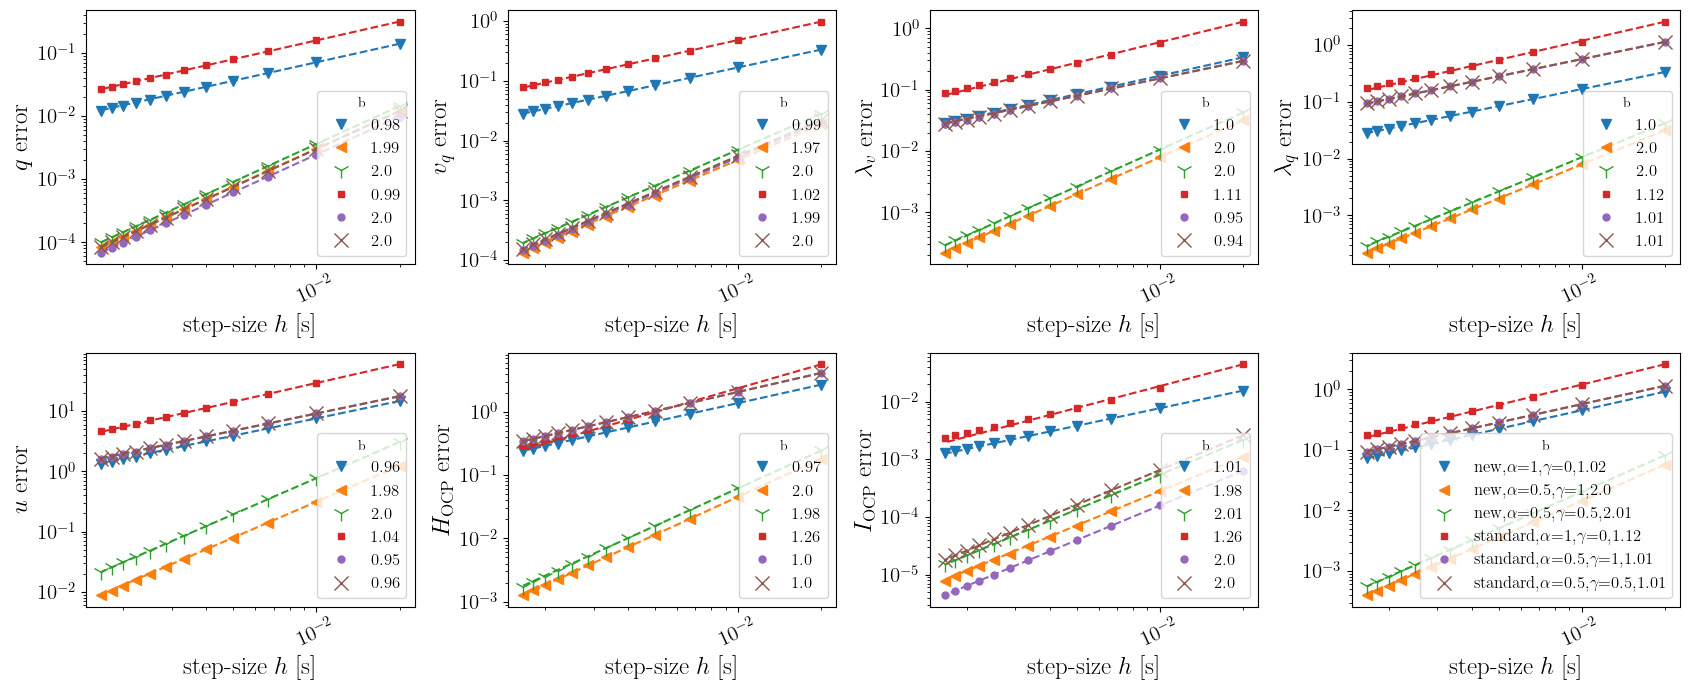

In [30]:
labelfont = 18
tickfont = 15
legendfont = 12

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "amsmath"
})

def create_error_plot(x_vals,error_data,labeltxt,axs_obj,markerstyle='x',markersize=8,colorstyle='blue'):
    fit_params = fit_to_data(x_vals,error_data)
    axs_obj.plot(x_vals,error_data,markerstyle,label=labeltxt + str(np.round(fit_params[0][1],2)),markersize=markersize,color=colorstyle)
    axs_obj.plot(x_vals,model_curve(x_vals,*fit_params[0]),'--',color=colorstyle)

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','C4','C5']
symbols = ['v','<','1','s','o','x']
symbolsizes = [7,7,12,5,5,10]
fig=plt.figure(figsize=(17, 7))
ax1 = plt.subplot(2,4,1)
ax2 = plt.subplot(2,4,2)
ax3 = plt.subplot(2,4,3)
ax4 = plt.subplot(2,4,4)
ax5 = plt.subplot(2,4,5)
ax6 = plt.subplot(2,4,6)
ax7 = plt.subplot(2,4,7)
ax8 = plt.subplot(2,4,8)
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]


chosen_ax = axs[0]
create_error_plot(h_choices,data_dicts_a1g0[0]["q_d_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["q_d_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["q_d_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["q_d_standard"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["q_d_standard"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["q_d_standard"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$q$ error',fontsize=labelfont)


chosen_ax =axs[1]
create_error_plot(h_choices,data_dicts_a1g0[0]["v_q_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["v_q_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["v_q_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["vq_d_standard"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["vq_d_standard"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["vq_d_standard"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$v_q$ error',fontsize=labelfont)

chosen_ax =axs[2]
create_error_plot(h_choices,data_dicts_a1g0[0]["lambda_v_d_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["lambda_v_d_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["lambda_v_d_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["lambda_v_standard"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["lambda_v_standard"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["lambda_v_standard"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$\lambda_v$ error',fontsize=labelfont)

chosen_ax =axs[3]
create_error_plot(h_choices,data_dicts_a1g0[0]["lambda_v_d_new"],r"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["lambda_v_d_new"],r"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["lambda_v_d_new"],r"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["lambda_q_standard"],r"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["lambda_q_standard"],r"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["lambda_q_standard"],r"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$\lambda_q$ error',fontsize=labelfont)


chosen_ax = axs[4]
create_error_plot(h_choices,data_dicts_a1g0[0]["u_d_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["u_d_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["u_d_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["u_d_standard"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["u_d_standard"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["u_d_standard"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$u$ error',fontsize=labelfont)

chosen_ax = axs[5]
create_error_plot(h_choices,data_dicts_a1g0[0]["H_control_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["H_control_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["H_control_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["H_pontry_standard"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["H_pontry_standard"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["H_pontry_standard"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])

chosen_ax.set_ylabel(r'$H_\mathrm{OCP}$ error',fontsize=labelfont)

chosen_ax = axs[6]
create_error_plot(h_choices,data_dicts_a1g0[0]["I_d_new"],"",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["I_d_new"],"",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["I_d_new"],"",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["I_standard_evo"],"",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["I_standard_evo"],"",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["I_standard_evo"],"",chosen_ax,symbols[5],symbolsizes[5],colors[5])
chosen_ax.set_ylabel(r'$I_\mathrm{OCP}$ error',fontsize=labelfont)

chosen_ax =axs[-1]
create_error_plot(h_choices,data_dicts_a1g0[0]["lambda_q_d_new"],r"new,$\alpha$=1,$\gamma$=0,",chosen_ax,symbols[0],symbolsizes[0],colors[0])
create_error_plot(h_choices,data_dicts_a1g1[0]["lambda_q_d_new"],r"new,$\alpha$=0.5,$\gamma$=1,",chosen_ax,symbols[1],symbolsizes[1],colors[1])
create_error_plot(h_choices,data_dicts_a05g05[0]["lambda_q_d_new"],r"new,$\alpha$=0.5,$\gamma$=0.5,",chosen_ax,symbols[2],symbolsizes[2],colors[2])
create_error_plot(h_choices,data_dicts_a1g0[1]["lambda_q_standard"],r"standard,$\alpha$=1,$\gamma$=0,",chosen_ax,symbols[3],symbolsizes[3],colors[3])
create_error_plot(h_choices,data_dicts_a1g1[1]["lambda_q_standard"],r"standard,$\alpha$=0.5,$\gamma$=1,",chosen_ax,symbols[4],symbolsizes[4],colors[4])
create_error_plot(h_choices,data_dicts_a05g05[1]["lambda_q_standard"],r"standard,$\alpha$=0.5,$\gamma$=0.5,",chosen_ax,symbols[5],symbolsizes[5],colors[5])


from matplotlib.ticker import StrMethodFormatter
for tmp in axs:
    tmp.legend(fontsize=legendfont,title='b')
    tmp.loglog()
    tmp.tick_params(labelsize=tickfont)
    tmp.tick_params(axis='x',which='both',labelsize=tickfont, rotation=25)
    tmp.set_xlabel(r'step-size $h$ [s]',fontsize=labelfont)   
plt.tight_layout()
plt.savefig('convergence_plot_force_control_final.pdf')

# Performance plots

In [31]:

comp_time_keys=['new_performance','standard_performance']
def get_function_evaluation_time_data_from(data_choice,N_vals,data_dict,alpha,gamma):
    list_chosen_data = []
    for tmp in N_vals:
        file_name_u =  "data_a="+str(alpha)+"g="+str(gamma)+"N="+str(tmp)+".pkl"   
        loaded_dict = data_dict[file_name_u]
        list_chosen_data.append(loaded_dict[data_choice])
    return np.array(list_chosen_data)

def get_function_evaluation_time_data_from_all(data_choices,N_vals,data_dict,alpha,gamma):
    list_times = []
    for tmp in data_choices:
        list_times.append(get_function_evaluation_time_data_from(tmp,N_vals,data_dict,alpha,gamma))
    return list_times    

#Extract the computation time data

single_comp_time_dicts = dict()

alpha_choice1,gamma_choice1=1,0
alpha_choice2,gamma_choice2=0.5,0.5
alpha_choice2,gamma_choice2=0.5,1

single_comp_time_dicts = dict()

for tmp in data.keys():
    # if (('a='+alpha_choice1) in tmp and  ('g='+gamma_choice1) in tmp) or (('a='+alpha_choice2) in tmp and  ('g='+gamma_choice2) in tmp) or (('a='+alpha_choice3) in tmp and  ('g='+gamma_choice3) in tmp):
    if 'standard_performance' in data[tmp][0].keys() and 'new_performance' in data[tmp][0].keys() :
        standard_key = 'standard_performance'
        new_key = 'new_performance'
        small_dict = {standard_key: data[tmp][0][standard_key], new_key: data[tmp][0][new_key] }
        single_comp_time_dicts[tmp] = small_dict

# "data_a="+str(alpha)+"g="+str(gamma)+"N="+str(tmp)+".pkl"

# for x in folder_names_comp_time:
#     if x == '.DS_Store':
#         continue
#     filename = comp_time_save_file_name+"/"+x 
#     with open(filename, 'rb') as files:
#         single_comp_time_dicts[x] = pickle.load(files) 

#concatenate all dicts
full_dict  = single_comp_time_dicts
# for tmp in single_comp_time_dicts:
#     for tmp2 in single_comp_time_dicts[tmp]:
#         full_dict[tmp2] = single_comp_time_dicts[tmp][tmp2]        


# create the data for plots

single_function_computation_time_plot_dataa1g05 = get_function_evaluation_time_data_from_all(comp_time_keys,N_choices,full_dict,0.5,0.5)
single_function_computation_time_plot_dataa05g1 = get_function_evaluation_time_data_from_all(comp_time_keys,N_choices,full_dict,0.5,1)
single_function_computation_time_plot_dataa1g1 = get_function_evaluation_time_data_from_all(comp_time_keys,N_choices,full_dict,1,0)
      

In [32]:

def get_run_time_data_from(data_choice,N_vals,data_dict,alpha,gamma):
    list_chosen_data = []
    for tmp in N_vals:
        file_name_u =  "data_a="+str(alpha)+"g="+str(gamma)+"N="+str(tmp)+".pkl"   
        loaded_dict = data_dict[file_name_u][0]
        list_chosen_data.append(loaded_dict[data_choice])
    return np.array(list_chosen_data)

def get_run_time_data_from_all(data_choices,N_vals,data_dict,alpha,gamma):
    list_times = []
    for tmp in data_choices:
        list_times.append(get_run_time_data_from(tmp,N_vals,data_dict,alpha,gamma))
    return list_times    

time_data_names = ['dt_new','dt_standard','Dt_new','Dt_standard','nfev_new','nfev_standard']    

alpha_choice = 1
gamma_choice = 0.5

def model_curve_time(x,a,b):
    return a*np.power(x,2)+b
def fit_to_data_choice(x_vals, data,model_curve):
    fit_result = scipy.optimize.curve_fit(model_curve,x_vals,data)
    return fit_result
def create_error_plot_choice(x_vals,error_data,labeltxt,axs_obj,markerstyle='x',markersize=8,colorstyle='blue',model_curve=model_curve_time):
    x_vals=np.array(x_vals)
    axs_obj.plot(x_vals,error_data,markerstyle,ls='--',label=labeltxt ,markersize=markersize,color=colorstyle)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


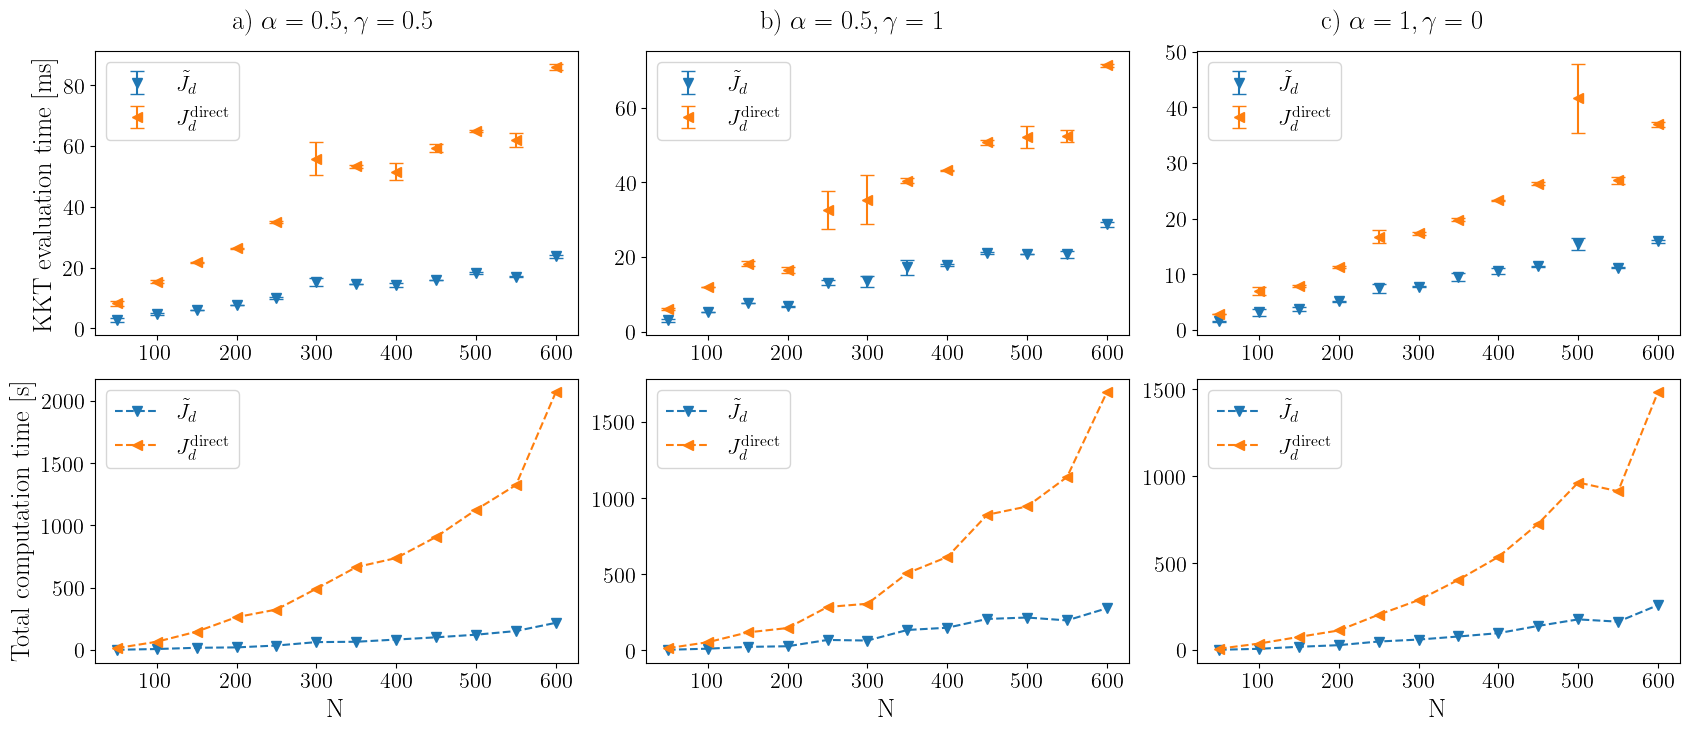

In [35]:
# bad_guess_folder = 'data/low_thrust/polar_variables_bad_initial_guess'
# data_bad_initial_guess = get_data_from_folder(bad_guess_folder)

labelfont = 19
tickfont = 16
legendfont = 16

alpha_choice = 0.5
gamma_choice = 0.5
testdata_times = get_run_time_data_from_all(time_data_names,N_choices,data,alpha_choice,gamma_choice)
# testdata_times_bad_init = get_run_time_data_from_all(time_data_names,N_choices,data_bad_initial_guess,alpha_choice,gamma_choice)

alpha_choice2 = 0.5
gamma_choice2 = 1
testdata_times2 = get_run_time_data_from_all(time_data_names,N_choices,data,alpha_choice2,gamma_choice2)
# testdata_times_bad_init2 = get_run_time_data_from_all(time_data_names,N_choices,data_bad_initial_guess,alpha_choice2,gamma_choice2)

alpha_choice3 = 1
gamma_choice3 = 0
testdata_times3 = get_run_time_data_from_all(time_data_names,N_choices,data,alpha_choice3,gamma_choice3)
# testdata_times_bad_init3 = get_run_time_data_from_all(time_data_names,N_choices,data_bad_initial_guess,alpha_choice3,gamma_choice3)

fig,axs = plt.subplots(2,3,figsize=(17, 7))

offset = 2
plot_nr = 0

# create_error_plot_choice(N_choices,testdata_times[plot_nr+offset],r"$\tilde{\mathcal{J}}_d$",axs[0][0],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 1
create_error_plot_choice(N_choices,testdata_times[plot_nr+offset],r"$\tilde{J}_d$",axs[1][0],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
plot_nr = 1
create_error_plot_choice(N_choices,testdata_times[plot_nr+offset],r"$J_d^\mathrm{direct}$",axs[1][0],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
plot_nr = 0
# create_error_plot_choice(N_choices,testdata_times2[plot_nr+offset],r"$\tilde{\mathcal{J}}_d$",axs[0][1],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 1
create_error_plot_choice(N_choices,testdata_times2[plot_nr+offset],r"$\tilde{J}_d$",axs[1][1],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
plot_nr = 1
create_error_plot_choice(N_choices,testdata_times2[plot_nr+offset],r"$J_d^\mathrm{direct}$",axs[1][1],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
plot_nr = 0
# create_error_plot_choice(N_choices,testdata_times3[plot_nr+offset],r"$\tilde{\mathcal{J}}_d$",axs[0][2],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 1
create_error_plot_choice(N_choices,testdata_times3[plot_nr+offset],r"$\tilde{J}_d$",axs[1][2],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
plot_nr = 1
create_error_plot_choice(N_choices,testdata_times3[plot_nr+offset],r"$J_d^\mathrm{direct}$",axs[1][2],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])



# offset = 3
# plot_nr = 0

# create_error_plot_choice(N_choices,testdata_times_bad_init[plot_nr+offset],r"$\tilde{\mathcal{J}}_d$",axs[1][0],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 1
# create_error_plot_choice(N_choices,testdata_times_bad_init[plot_nr+offset],r"$\tilde{\mathcal{J}}_d^\mathcal{E}$",axs[1][0],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 2
# create_error_plot_choice(N_choices,testdata_times_bad_init[plot_nr+offset],r"$J_d^\mathrm{direct}$",axs[1][0],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 0
# create_error_plot_choice(N_choices,testdata_times_bad_init2[plot_nr+offset],r"$\tilde{\mathcal{J}}_d$",axs[1][1],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 1
# create_error_plot_choice(N_choices,testdata_times_bad_init2[plot_nr+offset],r"$\tilde{\mathcal{J}}_d^\mathcal{E}$",axs[1][1],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 2
# create_error_plot_choice(N_choices,testdata_times_bad_init2[plot_nr+offset],r"$J_d^\mathrm{direct}$",axs[1][1],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 0
# create_error_plot_choice(N_choices,testdata_times_bad_init3[plot_nr+offset],r"$\tilde{\mathcal{J}}_d$",axs[1][2],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 1
# create_error_plot_choice(N_choices,testdata_times_bad_init3[plot_nr+offset],r"$\tilde{\mathcal{J}}_d^\mathcal{E}$",axs[1][2],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 2
# create_error_plot_choice(N_choices,testdata_times_bad_init3[plot_nr+offset],r"$J_d^\mathrm{direct}$",axs[1][2],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])



names = [[r"a) $\alpha=0.5,\gamma=0.5$",r"b) $\alpha=0.5,\gamma=1$",r"c) $\alpha=1,\gamma=0$"],[r"a) $\alpha=0.5,\gamma=0.5$",r"b) $\alpha=0.5,\gamma=1$",r"c) $\alpha=1,\gamma=0$"]]
for tmp2,tmpnames2 in zip(axs[0],names[0]):
    tmp2.legend(fontsize=legendfont)
    tmp2.tick_params(which='both',labelsize=tickfont)

plot_data = np.array(single_function_computation_time_plot_dataa1g05)*1e3
plot_nr =0
# axs[2][0].errorbar(N_choices, plot_data[plot_nr][:,0],capsize=5,yerr=plot_data[plot_nr][:,1],marker=symbols[plot_nr],markersize=symbolsizes[plot_nr],color=colors[plot_nr],linestyle='None',label=r"$\tilde{\mathcal{J}}_d$")
plot_nr =0
axs[0][0].errorbar(N_choices, plot_data[plot_nr][:,0],capsize=5,yerr=plot_data[plot_nr][:,1],marker=symbols[plot_nr],markersize=symbolsizes[plot_nr],color=colors[plot_nr],linestyle='None',label=r"$\tilde{J}_d$")
plot_nr = 1
axs[0][0].errorbar(N_choices, plot_data[plot_nr][:,0],capsize=5,yerr=plot_data[plot_nr][:,1],marker=symbols[plot_nr],markersize=symbolsizes[plot_nr],color=colors[plot_nr],linestyle='None',label=r"$J_d^\mathrm{direct}$")

plot_data = np.array(single_function_computation_time_plot_dataa05g1)*1e3
plot_nr =0
# axs[2][1].errorbar(N_choices, plot_data[plot_nr][:,0],capsize=5,yerr=plot_data[plot_nr][:,1],marker=symbols[plot_nr],markersize=symbolsizes[plot_nr],color=colors[plot_nr],linestyle='None',label=r"$\tilde{\mathcal{J}}_d$")
# plot_nr =1
axs[0][1].errorbar(N_choices, plot_data[plot_nr][:,0],capsize=5,yerr=plot_data[plot_nr][:,1],marker=symbols[plot_nr],markersize=symbolsizes[plot_nr],color=colors[plot_nr],linestyle='None',label=r"$\tilde{J}_d$")
plot_nr = 1
axs[0][1].errorbar(N_choices, plot_data[plot_nr][:,0],capsize=5,yerr=plot_data[plot_nr][:,1],marker=symbols[plot_nr],markersize=symbolsizes[plot_nr],color=colors[plot_nr],linestyle='None',label=r"$J_d^\mathrm{direct}$")


plot_data = np.array(single_function_computation_time_plot_dataa1g1)*1e3
plot_nr =0
# axs[2][2].errorbar(N_choices, plot_data[plot_nr][:,0],capsize=5,yerr=plot_data[plot_nr][:,1],marker=symbols[plot_nr],markersize=symbolsizes[plot_nr],color=colors[plot_nr],linestyle='None',label=r"$\tilde{\mathcal{J}}_d$")
# plot_nr =1
axs[0][2].errorbar(N_choices, plot_data[plot_nr][:,0],capsize=5,yerr=plot_data[plot_nr][:,1],marker=symbols[plot_nr],markersize=symbolsizes[plot_nr],color=colors[plot_nr],linestyle='None',label=r"$\tilde{J}_d$")
plot_nr = 1
axs[0][2].errorbar(N_choices, plot_data[plot_nr][:,0],capsize=5,yerr=plot_data[plot_nr][:,1],marker=symbols[plot_nr],markersize=symbolsizes[plot_nr],color=colors[plot_nr],linestyle='None',label=r"$J_d^\mathrm{direct}$")

axs[1][0].set_ylabel(r'Total computation time [s]',fontsize=labelfont)
# axs[1][0].set_ylabel(r'Total computation time [s]',fontsize=labelfont)
axs[0][0].set_ylabel('KKT evaluation time [ms]',fontsize=labelfont)




# offset = 4
# plot_nr = 0

# # create_error_plot_choice(N_choices,testdata_times[plot_nr+offset],r"$\tilde{\mathcal{J}}_d$",axs[0][0],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# # plot_nr = 1
# create_error_plot_choice(N_choices,testdata_times[plot_nr+offset],r"$\tilde{\mathcal{J}}_d^\mathcal{E}$",axs[2][0],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 1
# create_error_plot_choice(N_choices,testdata_times[plot_nr+offset],r"$J_d^\mathrm{direct}$",axs[2][0],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 0
# # create_error_plot_choice(N_choices,testdata_times2[plot_nr+offset],r"$\tilde{\mathcal{J}}_d$",axs[0][1],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# # plot_nr = 1
# create_error_plot_choice(N_choices,testdata_times2[plot_nr+offset],r"$\tilde{\mathcal{J}}_d^\mathcal{E}$",axs[2][1],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 1
# create_error_plot_choice(N_choices,testdata_times2[plot_nr+offset],r"$J_d^\mathrm{direct}$",axs[2][1],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 0
# # create_error_plot_choice(N_choices,testdata_times3[plot_nr+offset],r"$\tilde{\mathcal{J}}_d$",axs[0][2],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# # plot_nr = 1
# create_error_plot_choice(N_choices,testdata_times3[plot_nr+offset],r"$\tilde{\mathcal{J}}_d^\mathcal{E}$",axs[2][2],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])
# plot_nr = 1
# create_error_plot_choice(N_choices,testdata_times3[plot_nr+offset],r"$J_d^\mathrm{direct}$",axs[2][2],symbols[plot_nr],symbolsizes[plot_nr],colors[plot_nr])



for tmp in axs[-1]:
    tmp.set_xlabel('N',fontsize=labelfont)


for axs_tmp in axs:
    for tmp2,tmpnames2 in zip(axs_tmp,names[0]):
        tmp2.legend(title_fontsize=legendfont,fontsize=legendfont)
        tmp2.tick_params(which='both',labelsize=tickfont)



  
fig.text(0.14,1.01,names[0][0],fontsize=labelfont)
fig.text(0.45,1.01,names[0][1],fontsize=labelfont)
fig.text(0.78,1.01,names[0][2],fontsize=labelfont)


plt.tight_layout()

bbox = fig.get_tightbbox(fig.canvas.get_renderer())
x0,y0,width,height = bbox.transformed(fig.transFigure.inverted()).bounds

ypad=20.5*height
width = 101*width
height=1.3*30*height
xpad=0*width
# fig.text(-0.023,0.76,r'good initial guess',rotation='vertical',fontsize=labelfont)
# fig.text(-0.023,0.43,r'bad initial guess',rotation='vertical',fontsize=labelfont)

plt.savefig('Forced_total_time_comparison_full.pdf',bbox_inches='tight',edgecolor=fig.get_edgecolor())


# Rigid body figure

In [123]:
base_folder_dir = 'data/rigid_body'
def get_data_from_folder(foldername):
    folder_names = os.listdir(foldername+'/')
    dict_of_folders_with_files = dict()
    for x in folder_names:
        if x != '.DS_Store':
            dict_of_folders_with_files[x] = create_dict_for_folder(foldername+'/' +x)
    #Structure of data dict:
        # data_dict["folder_name"]=[ {"file_name":data}, [alpha,beta,gamma,h] ]
    data_dict = dict()
    for x in dict_of_folders_with_files.keys():
        for y in dict_of_folders_with_files[x].keys():
            if y == '.DS_Store':
                continue

            filename = foldername+"/"+x + "/"+y
            with open(filename, 'rb') as files:
                data_dict[y] = [pickle.load(files) ,dict_of_folders_with_files[x][y]]
    return data_dict            

base_folder_dir_test = base_folder_dir
base_foldername = base_folder_dir_test 
data_rigid=get_data_from_folder(base_foldername)

In [129]:
plot_data = data_rigid['data_v0a=1g=0.5N=50.pkl'][0]
plot_data.keys()

dict_keys(['parameters', 'q_d_new', 'q_d_new_cartesian', 'lambda_d_new', 'p_y_d_new', 'U1_d_new', 'U2_d_new', 'u_d_new', 'H_control_new', 'v_y_d_new', 'mu_sol', 'nu_sol', 'basis_rotation_evo'])

In [ ]:
plot_data = data_rigid['data_v0a=1g=0.5N=50.pkl'][0]

times = plot_data['parameters']['times']
q_rigid_body = plot_data['q_d_new']
xi_rigid_body = plot_data['lambda_d_new']
v_y_rigid_body = plot_data['v_y_d_new']
basis_rigid_body_evo = plot_data['basis_rotation_evo']

